# Intro to Object Detection Colab

Welcome to the object detection colab! This demo will take you through the steps of running an "out-of-the-box" detection model in SavedModel format on a collection of images.



Imports

In [1]:
import sys
sys.path.append("/cnvrg/tf/models/research")

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [2]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from tensorflow.keras.models import save_model, load_model
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

In [16]:
def load_image_into_numpy_array(path, new_size=1024):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  image.thumbnail((new_size, new_size), Image.ANTIALIAS)
#   (im_width, im_height) = image.size
#   return np.array(image.getdata()).reshape(
#       (im_height, im_width, 3)).astype(np.uint8)
  image = np.array(image)
  if image.shape[-1] == 4:
    image = image[:,:,:3]
  return image

category_index = {
    1: {'id': 1, 'name': 'bottom'},
    2: {'id': 2, 'name': 'top'},
}

# # Load the COCO Label Map
# category_index = {
#     1: {'id': 1, 'name': 'person'},
#     2: {'id': 2, 'name': 'bicycle'},
#     3: {'id': 3, 'name': 'car'},
#     4: {'id': 4, 'name': 'motorcycle'},
#     5: {'id': 5, 'name': 'airplane'},
#     6: {'id': 6, 'name': 'bus'},
#     7: {'id': 7, 'name': 'train'},
#     8: {'id': 8, 'name': 'truck'},
#     9: {'id': 9, 'name': 'boat'},
#     10: {'id': 10, 'name': 'traffic light'},
#     11: {'id': 11, 'name': 'fire hydrant'},
#     13: {'id': 13, 'name': 'stop sign'},
#     14: {'id': 14, 'name': 'parking meter'},
#     15: {'id': 15, 'name': 'bench'},
#     16: {'id': 16, 'name': 'bird'},
#     17: {'id': 17, 'name': 'cat'},
#     18: {'id': 18, 'name': 'dog'},
#     19: {'id': 19, 'name': 'horse'},
#     20: {'id': 20, 'name': 'sheep'},
#     21: {'id': 21, 'name': 'cow'},
#     22: {'id': 22, 'name': 'elephant'},
#     23: {'id': 23, 'name': 'bear'},
#     24: {'id': 24, 'name': 'zebra'},
#     25: {'id': 25, 'name': 'giraffe'},
#     27: {'id': 27, 'name': 'backpack'},
#     28: {'id': 28, 'name': 'umbrella'},
#     31: {'id': 31, 'name': 'handbag'},
#     32: {'id': 32, 'name': 'tie'},
#     33: {'id': 33, 'name': 'suitcase'},
#     34: {'id': 34, 'name': 'frisbee'},
#     35: {'id': 35, 'name': 'skis'},
#     36: {'id': 36, 'name': 'snowboard'},
#     37: {'id': 37, 'name': 'sports ball'},
#     38: {'id': 38, 'name': 'kite'},
#     39: {'id': 39, 'name': 'baseball bat'},
#     40: {'id': 40, 'name': 'baseball glove'},
#     41: {'id': 41, 'name': 'skateboard'},
#     42: {'id': 42, 'name': 'surfboard'},
#     43: {'id': 43, 'name': 'tennis racket'},
#     44: {'id': 44, 'name': 'bottle'},
#     46: {'id': 46, 'name': 'wine glass'},
#     47: {'id': 47, 'name': 'cup'},
#     48: {'id': 48, 'name': 'fork'},
#     49: {'id': 49, 'name': 'knife'},
#     50: {'id': 50, 'name': 'spoon'},
#     51: {'id': 51, 'name': 'bowl'},
#     52: {'id': 52, 'name': 'banana'},
#     53: {'id': 53, 'name': 'apple'},
#     54: {'id': 54, 'name': 'sandwich'},
#     55: {'id': 55, 'name': 'orange'},
#     56: {'id': 56, 'name': 'broccoli'},
#     57: {'id': 57, 'name': 'carrot'},
#     58: {'id': 58, 'name': 'hot dog'},
#     59: {'id': 59, 'name': 'pizza'},
#     60: {'id': 60, 'name': 'donut'},
#     61: {'id': 61, 'name': 'cake'},
#     62: {'id': 62, 'name': 'chair'},
#     63: {'id': 63, 'name': 'couch'},
#     64: {'id': 64, 'name': 'potted plant'},
#     65: {'id': 65, 'name': 'bed'},
#     67: {'id': 67, 'name': 'dining table'},
#     70: {'id': 70, 'name': 'toilet'},
#     72: {'id': 72, 'name': 'tv'},
#     73: {'id': 73, 'name': 'laptop'},
#     74: {'id': 74, 'name': 'mouse'},
#     75: {'id': 75, 'name': 'remote'},
#     76: {'id': 76, 'name': 'keyboard'},
#     77: {'id': 77, 'name': 'cell phone'},
#     78: {'id': 78, 'name': 'microwave'},
#     79: {'id': 79, 'name': 'oven'},
#     80: {'id': 80, 'name': 'toaster'},
#     81: {'id': 81, 'name': 'sink'},
#     82: {'id': 82, 'name': 'refrigerator'},
#     84: {'id': 84, 'name': 'book'},
#     85: {'id': 85, 'name': 'clock'},
#     86: {'id': 86, 'name': 'vase'},
#     87: {'id': 87, 'name': 'scissors'},
#     88: {'id': 88, 'name': 'teddy bear'},
#     89: {'id': 89, 'name': 'hair drier'},
#     90: {'id': 90, 'name': 'toothbrush'},
# }

In [ ]:
# Download the saved model and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d5_coco17_tpu-32.tar.gz
!mv efficientdet_d5_coco17_tpu-32/ models/research/object_detection/test_data/

In [4]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/cnvrg/research-segmentation-clothes/output/efficientdet_vanilla/ckpt-129-inference/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 26.43434238433838s


  0% (1 of 297) |                        | Elapsed Time: 0:00:00 ETA:   0:03:39/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100% (297 of 297) |######################| Elapsed Time: 0:02:26 Time:  0:02:26


Elapsed time: 0.03702870121708623 second per image


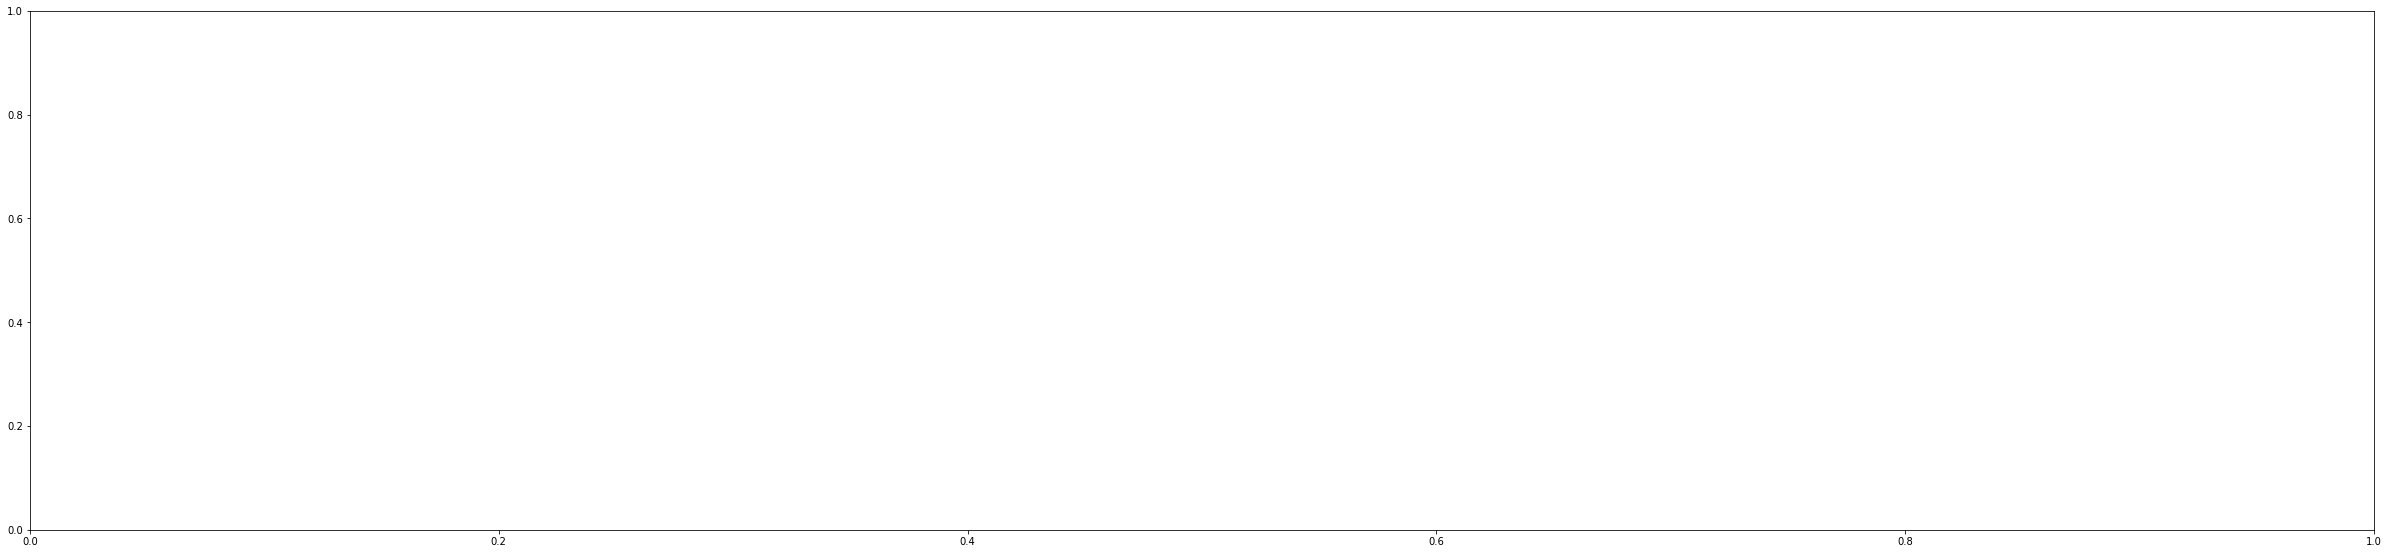

In [19]:
import time, glob, progressbar

image_dir = '/data/clothes_seg_test_sets/images_300'
def basename_no_ext(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

image_list = glob.glob(os.path.join(image_dir, "*"))
elapsed = []
for image_path in progressbar.progressbar(image_list):
  #image_path = os.path.join(image_dir, 'image' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
  plt.subplot(2, 1, i+1)
  #plt.imshow(image_np_with_detections)
  plt.imsave(os.path.join("/cnvrg/output/efficientdet_vanilla/test300_vis", basename_no_ext(image_path) + ".png"), image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

In [7]:
detect_fn

NameError: name 'detect_fn' is not defined